## Imports and Hyperparameters

In [11]:
import os
import glob
import random

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

from classifiers.WDI_1NN import WDI_1NN
from classifiers.ACM_SVM import ACM_SVM
from classifiers.CASIM import CASIM
from classifiers.EAC_1NN import EAC_1NN
from classifiers.MBW_LR import MBW_LR

In [14]:
RANDOM_SEED = 42
N_REPEATS = 10
N_SPLITS = 5
MAX_DATA_LENGTH = 60
PERTURBATION_STEP_SIZE = 0.10

SAVE_DIR_TEP = "results/tep"
SAVE_DIR_FCC = "results/fcc"

# Order of parameters: [params_dict, use_argmin, stepwise_train]
wdi_1nn_params = [{"template_threshold": 0.5, "n_neighbors": 1}, False, True]
acm_svm_params = [{None}, False, False]
casim_params=[{
        "num_features": 672,
        "n_estimators": 1,
        "n_jobs_multirocket": 1,
        "random_state": RANDOM_SEED,
        "alphas": np.logspace(-3, 3, 10),
    }, False, True]
eac_1nn_params = [{"attenuation_coefficient_per_min": 0.0667}, False, True]
mbw_lr_params = [{
        "penalty": None,
        "fit_intercept": False,
        "solver": "lbfgs",
        "multi_class": "ovr",
        "decision_bounds": True,
        "confidence_interval": 1.96,
    }, False, True]

CLASSIFIERS = {
    "WDI_1NN": (WDI_1NN, wdi_1nn_params),
    "CASIM": (CASIM, casim_params),
    "EAC_1NN": (EAC_1NN, eac_1nn_params),
    "MBW_LR": (MBW_LR, mbw_lr_params),
    "ACM_SVM": (ACM_SVM, acm_svm_params),
}

## Load Data and Original Labels

In [3]:
def load_dataset_from_folder(base_path, max_data_length):
    """
    Load time-series CSV files organized in subfolders per class.

    Parameters
    - base_path: str or Path to the folder containing one subfolder per class.
                 Each class subfolder should contain CSV files (all same shape).
    - max_data_length: int, maximum length of the time series data (number of timesteps).

    Returns
    - X: numpy array of shape (n_samples, n_variables, n_timesteps)
    - y: numpy array of integer labels (0..n_classes-1)

    Prints shapes of X and y.
    """

    data = []
    labels = []

    # Find subfolders (classes) in deterministic order
    class_folders = sorted(
        [
            d for d in os.listdir(base_path)
            if os.path.isdir(os.path.join(base_path, d))
        ]
    )
    if not class_folders:
        raise ValueError(f"No class subfolders found in {base_path}")

    # Build list of files to load (with labels) to show a single progress bar
    files_to_load = []
    for label, class_name in enumerate(class_folders):
        class_dir = os.path.join(base_path, class_name)
        # Collect CSV files in deterministic order
        csv_files = sorted(
            [
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f)) and f.lower().endswith(".csv")
            ]
        )
        if not csv_files:
            raise ValueError(f"No CSV files found in class folder {class_dir}")

        for fname in csv_files:
            files_to_load.append((os.path.join(class_dir, fname), label))

    # Iterate with tqdm progress bar
    for csv_path, label in tqdm(files_to_load, desc="Loading dataset", unit="file"):
        df = pd.read_csv(csv_path, index_col=0)
        arr = df.values.T  # transpose to match original layout: (variables, timesteps)
        data.append(arr)
        labels.append(label)

    # Ensure all samples have the same shape
    shapes = {a.shape for a in data}
    if len(shapes) != 1:
        raise ValueError(f"Inconsistent sample shapes found: {shapes}")

    X = np.array(data)
    y = np.array(labels)

    # Resize data to max_data_length if necessary
    if X.shape[2] > max_data_length:
        X = X[:, :, :max_data_length]

    print("Data shape: {}".format(X.shape))
    print("Labels shape: {}".format(y.shape))

    return X, y

## Label Perturbation

In [4]:
class LabelPerturber:
    """Class to handle label perturbation operations"""
    
    def __init__(self, random_state=None):
        self.random_state = random_state
        
    def perturb_labels(self, y, perturbation_level, perturbation_step_size=0.1):
        """
        Perturb labels by randomly changing a percentage of them to other classes.
        
        Parameters:
        - y: array of labels
        - perturbation_level: integer step level (0 = no perturbation)
        - perturbation_step_size: percentage per step (e.g., 0.1 = 10% per step)
        
        Returns:
        - perturbed labels array
        """
        if perturbation_level == 0:
            return y.copy()
            
        np.random.seed(self.random_state)
        y_perturbed = y.copy()
        unique_classes = np.unique(y)
        num_samples = len(y)
        num_perturb = int(num_samples * perturbation_step_size * perturbation_level)
        
        if num_perturb == 0:
            return y_perturbed
            
        perturbed_indices = np.random.choice(num_samples, size=num_perturb, replace=False)
        
        for index in perturbed_indices:
            original_label = y[index]
            possible_perturbations = [cls for cls in unique_classes if cls != original_label]
            new_label = np.random.choice(possible_perturbations)
            y_perturbed[index] = new_label
            
        return y_perturbed

## Robustness Tester

In [5]:
class RobustnessTester:
    """Class to test model robustness against label perturbations"""
    
    def __init__(self, classifiers_dict, perturber, n_splits=5, perturbation_step_size=0.1, 
                 random_state=None):
        """
        Parameters:
        - classifiers_dict: dictionary with classifier info {name: (class, params)}
        - perturber: LabelPerturber instance
        - n_splits: number of CV folds
        - perturbation_step_size: percentage per perturbation step
        - random_state: random seed for reproducibility
        """
        self.classifiers_dict = classifiers_dict
        self.perturber = perturber
        self.n_splits = n_splits
        self.perturbation_step_size = perturbation_step_size
        self.random_state = random_state
        
    def test_robustness(self, X, y, classifier_name, perturbation_steps=10):
        """
        Test robustness of a specific classifier against label perturbation.
        
        Parameters:
        - X: feature data
        - y: labels
        - classifier_name: name of classifier to test (key in classifiers_dict)
        - perturbation_steps: maximum perturbation level to test
        
        Returns:
        - results DataFrame with accuracy for each fold and perturbation level
        - confusion_matrices DataFrame with aggregated confusion matrices
        """
        if classifier_name not in self.classifiers_dict:
            raise ValueError(f"Classifier '{classifier_name}' not found in classifiers_dict")
            
        classifier_class, classifier_params = self.classifiers_dict[classifier_name]
        params_dict = classifier_params[0]
        
        np.random.seed(self.random_state)
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        
        fold_results = []
        confusion_matrices = []
        
        for step in range(0, perturbation_steps + 1):
            print(f"Testing {classifier_name} - Perturbation step {step}...")

            step_confusion_matrix = None
            
            for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                
                # Perturb training labels
                y_train_perturbed = self.perturber.perturb_labels(
                    y_train, step, self.perturbation_step_size
                )
                
                # Train model on perturbed data
                model_instance = classifier_class(params_dict)
                model_instance.fit(X_train, y_train_perturbed)
                
                # Evaluate on unperturbed test data
                y_pred = model_instance.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                
                fold_results.append({
                    'classifier': classifier_name,
                    'fold': fold,
                    'perturbation_percentage': round(self.perturbation_step_size * step * 100),
                    'accuracy': accuracy
                })
                
                # Accumulate confusion matrix
                cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
                if step_confusion_matrix is None:
                    step_confusion_matrix = cm
                else:
                    step_confusion_matrix += cm
            
            # Store aggregated confusion matrix for this perturbation level
            cm_flat = step_confusion_matrix.flatten()
            cm_dict = {f'cm_{i}_{j}': cm_flat[i * len(np.unique(y)) + j] 
                      for i in range(len(np.unique(y))) 
                      for j in range(len(np.unique(y)))}
            cm_dict['classifier'] = classifier_name
            cm_dict['perturbation_percentage'] = round(self.perturbation_step_size * step * 100)
            confusion_matrices.append(cm_dict)
        
        # Process results
        results_df = pd.DataFrame(fold_results)
        results_pivot = results_df.pivot_table(
            index='perturbation_percentage', 
            columns='fold', 
            values='accuracy'
        )
        results_pivot['average'] = results_pivot.mean(axis=1)
        
        cm_df = pd.DataFrame(confusion_matrices).set_index('perturbation_percentage')
        
        return results_pivot, cm_df
    
    def test_all_classifiers(self, X, y, perturbation_steps=10, results_folder=None):
        """
        Test robustness of all classifiers in the dictionary.
        
        Parameters:
        - X: feature data
        - y: labels  
        - perturbation_steps: maximum perturbation level to test
        - results_folder: folder to save results CSV files

        Returns:
        - Dictionary with results for each classifier
        """
        all_results = {}
        
        for classifier_name in self.classifiers_dict.keys():
            print(f"\nTesting robustness of {classifier_name}...")
            
            results, cm = self.test_robustness(X, y, classifier_name, perturbation_steps)
            all_results[classifier_name] = {'results': results, 'confusion_matrices': cm}
            
            if results_folder is not None:
                os.makedirs(results_folder, exist_ok=True)
                results.to_csv(f"{results_folder}/{classifier_name}_robustness_results.csv")
                cm.to_csv(f"{results_folder}/{classifier_name}_confusion_matrices.csv")
        
        return all_results

## Visualization

In [16]:
def plot_robustness_results(classifiers_dict, results_folder, save_filename=None):
    """
    Load robustness results and create a visualization plot.
    
    Parameters:
    - classifiers_dict: dictionary of classifiers used in the experiment
    - results_folder: path to folder containing the results CSV files
    - save_filename: optional filename to save the plot (with .svg extension)
    """
    # Load all robustness results CSV files
    files = glob.glob(f'{results_folder}/*_robustness_results.csv')
    
    if not files:
        print(f"No robustness results files found in {results_folder}")
        return
    
    # Initialize a dictionary to store data
    data = {}
    x_labels = None
    
    # Read each file and store the average column
    for file in files:
        # Extract classifier name from filename
        filename = os.path.basename(file)
        classifier_name = filename.replace('_robustness_results.csv', '')
        
        if classifier_name in classifiers_dict:
            df = pd.read_csv(file, index_col=0)
            data[classifier_name] = df['average']
            if x_labels is None:
                x_labels = df.index  # perturbation_percentage values
    
    if not data:
        print("No valid classifier data found")
        return
    
    # Create a DataFrame from the dictionary
    results_df = pd.DataFrame(data)
    
    # Define diverse styles for each classifier
    colors = ['#00B0F0', '#12B65C', '#FFC000', '#FF0400', '#A52A2A', '#800080', '#FFA500', '#008000']
    linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':']
    markers = ['o', 's', '^', 'v', 'D', 'X', '*', 'P']
    
    markersize = 8
    linewidth = 2.5
    
    # Create style dictionary for each classifier
    styles = {}
    for i, classifier in enumerate(data.keys()):
        styles[classifier] = {
            'color': colors[i % len(colors)],
            'linestyle': linestyles[i % len(linestyles)],
            'marker': markers[i % len(markers)],
            'markersize': markersize,
            'linewidth': linewidth
        }
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for classifier, style in styles.items():
        ax.plot(x_labels, results_df[classifier], label=classifier, **style)
    
    plt.title('Classifier Robustness to Label Perturbation')
    plt.xlabel('Perturbation Percentage (%)')
    plt.ylabel('Average Accuracy')
    plt.ylim(-0.1, 1.1)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(title='Classifier')
    
    # Save the plot if filename provided
    if save_filename:
        plt.savefig(f'{results_folder}/{save_filename}')
    
    plt.show()

## Experiments

### Tennessee-Eastman Process (TEP)

In [7]:
X, y = load_dataset_from_folder("data/tep", MAX_DATA_LENGTH)

Loading dataset: 100%|██████████| 1000/1000 [00:01<00:00, 577.97file/s]


Data shape: (1000, 50, 60)
Labels shape: (1000,)


In [8]:
perturber = LabelPerturber(random_state=RANDOM_SEED)
robustness_tester = RobustnessTester(
    classifiers_dict=CLASSIFIERS,
    perturber=perturber,
    n_splits=N_SPLITS,
    perturbation_step_size=PERTURBATION_STEP_SIZE,
    random_state=RANDOM_SEED
)
robustness_tester.test_all_classifiers(X, y, perturbation_steps=10, results_folder=SAVE_DIR_TEP)


Testing robustness of EAC_1NN...
Testing EAC_1NN - Perturbation step 0...
Testing EAC_1NN - Perturbation step 1...
Testing EAC_1NN - Perturbation step 2...
Testing EAC_1NN - Perturbation step 3...
Testing EAC_1NN - Perturbation step 4...
Testing EAC_1NN - Perturbation step 5...
Testing EAC_1NN - Perturbation step 6...
Testing EAC_1NN - Perturbation step 7...
Testing EAC_1NN - Perturbation step 8...
Testing EAC_1NN - Perturbation step 9...
Testing EAC_1NN - Perturbation step 10...


{'EAC_1NN': {'results': fold                         0      1      2      3      4  average
  perturbation_percentage                                            
  0                        0.895  0.930  0.905  0.910  0.935    0.915
  10                       0.775  0.795  0.775  0.725  0.780    0.770
  20                       0.720  0.660  0.750  0.660  0.635    0.685
  30                       0.630  0.555  0.700  0.560  0.510    0.591
  40                       0.550  0.515  0.615  0.465  0.430    0.515
  50                       0.490  0.425  0.585  0.415  0.335    0.450
  60                       0.350  0.350  0.500  0.335  0.290    0.365
  70                       0.280  0.275  0.340  0.260  0.255    0.282
  80                       0.180  0.190  0.215  0.195  0.160    0.188
  90                       0.125  0.090  0.165  0.120  0.110    0.122
  100                      0.025  0.010  0.015  0.010  0.025    0.017,
  'confusion_matrices':                          cm_0_0  cm_0_1  cm

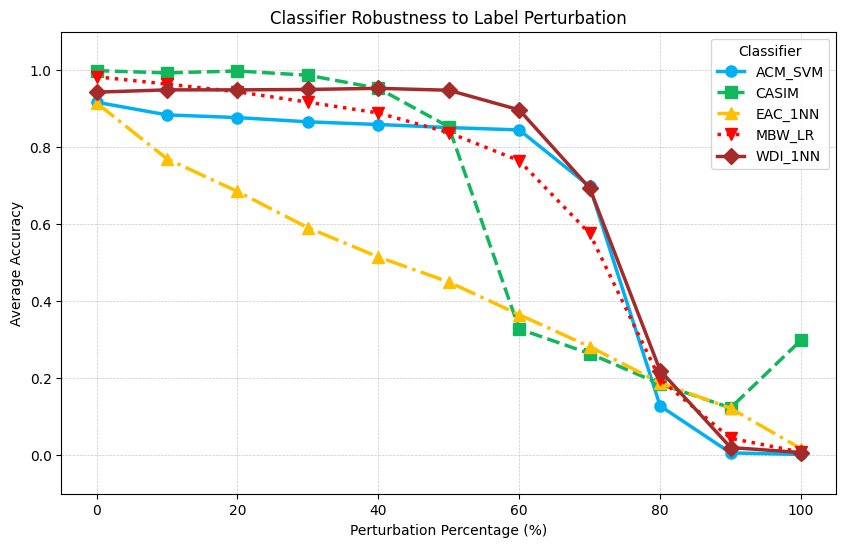

In [17]:
plot_robustness_results(CLASSIFIERS, SAVE_DIR_TEP, save_filename='tep_robustness_plot.svg')

### Fluidized Catalytic Cracking (FCC)

In [9]:
X, y = load_dataset_from_folder("data/fcc", MAX_DATA_LENGTH)

Loading dataset: 100%|██████████| 1600/1600 [00:02<00:00, 644.18file/s]

Data shape: (1600, 57, 60)
Labels shape: (1600,)


In [10]:
perturber = LabelPerturber(random_state=RANDOM_SEED)
robustness_tester = RobustnessTester(
    classifiers_dict=CLASSIFIERS,
    perturber=perturber,
    n_splits=N_SPLITS,
    perturbation_step_size=PERTURBATION_STEP_SIZE,
    random_state=RANDOM_SEED
)
robustness_tester.test_all_classifiers(X, y, perturbation_steps=10, results_folder=SAVE_DIR_FCC)


Testing robustness of EAC_1NN...
Testing EAC_1NN - Perturbation step 0...
Testing EAC_1NN - Perturbation step 1...
Testing EAC_1NN - Perturbation step 2...
Testing EAC_1NN - Perturbation step 3...
Testing EAC_1NN - Perturbation step 4...
Testing EAC_1NN - Perturbation step 5...
Testing EAC_1NN - Perturbation step 6...
Testing EAC_1NN - Perturbation step 7...
Testing EAC_1NN - Perturbation step 8...
Testing EAC_1NN - Perturbation step 9...
Testing EAC_1NN - Perturbation step 10...


{'EAC_1NN': {'results': fold                            0         1         2         3         4  \
  perturbation_percentage                                                     
  0                        0.975000  0.990625  0.993750  0.984375  0.990625   
  10                       0.834375  0.834375  0.865625  0.887500  0.868750   
  20                       0.687500  0.759375  0.743750  0.771875  0.718750   
  30                       0.593750  0.690625  0.675000  0.693750  0.615625   
  40                       0.525000  0.562500  0.603125  0.559375  0.496875   
  50                       0.459375  0.490625  0.521875  0.475000  0.421875   
  60                       0.378125  0.390625  0.443750  0.393750  0.340625   
  70                       0.296875  0.300000  0.325000  0.303125  0.240625   
  80                       0.203125  0.178125  0.218750  0.203125  0.175000   
  90                       0.093750  0.103125  0.103125  0.109375  0.112500   
  100                      0.0

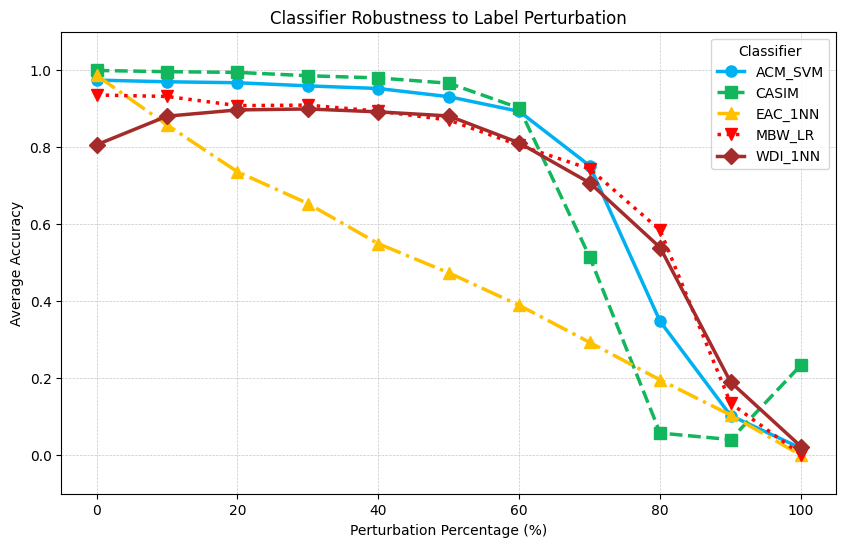

In [18]:
plot_robustness_results(CLASSIFIERS, SAVE_DIR_FCC, save_filename='fcc_robustness_plot.svg')